In [1]:
# install dependencies
!pip install numpyro pyro-ppl torch jax

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import binom
import scipy.stats as st
import torch

# jax
import jax.numpy as jnp
from jax import lax, random

# pyro
import pyro
from pyro import distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import MCMC, NUTS, SVI, ELBO, Trace_ELBO
from pyro.optim import Adam

# numpyro
import numpyro
from numpyro import distributions as ndist
import numpyro.distributions.constraints as nconstraints
from numpyro.infer import MCMC as nMCMC
from numpyro.infer import NUTS as nNUTS
from numpyro.infer import SVI as nSVI
from numpyro.infer import ELBO as nELBO
from numpyro.infer import Trace_ELBO as nTrace_ELBO
from numpyro.optim import Adam as nAdam


%matplotlib inline

In [3]:
def simulate_draw(theta, n):
    """
    Draws a Bernoulli sample of size n with probability P(Y=1) = theta
    """
    rand_draw = np.random.rand(n)
    draw = (rand_draw < theta).astype(int)
    return draw


def analytical_beta_posterior(data, alpha0, beta0):
    """
    Computes analytically the posterior distribution with beta prior parametrized by (alpha, beta) 
    given # num observations

    Parameters
    ---------
    num : int.
        the number of observations after which we calculate the posterior
    alpha0, beta0 : float.
        the parameters for the beta distribution as a prior

    Returns
    --------- 
    The posterior beta distribution
    """
    num = len(data)
    up_num = data.sum()
    down_num = num - up_num
    return st.beta(alpha0 + up_num, beta0 + down_num)

In [4]:
# used by Numpyro
def TruncatedLogNormal_trans(loc, scale):
    """
    Obtains the truncated log normal distribution using numpyro's TruncatedNormal and ExpTransform
    """
    base_dist = ndist.TruncatedNormal(low=jnp.log(0), high=jnp.log(1), loc=loc, scale=scale)
    return ndist.TransformedDistribution(
        base_dist,ndist.transforms.ExpTransform()
        )

def ShiftedVonMises(kappa):
    """
    Obtains the shifted von Mises distribution using AffineTransform
    """
    base_dist = ndist.VonMises(0, kappa)
    return ndist.TransformedDistribution(
        base_dist, ndist.transforms.AffineTransform(loc=0.5, scale=1/(2*jnp.pi))
        )

def TruncatedLaplace(loc, scale):
    """
    Obtains the truncated Laplace distribution on [0,1]
    """
    base_dist = ndist.Laplace(loc, scale)
    return ndist.TruncatedDistribution(
        base_dist, low=0.0, high=1.0
    )
    
# used by Pyro
class TruncatedLogNormal(dist.Rejector):
    """
    Define a TruncatedLogNormal distribution through rejection sampling in Pyro
    """
    def __init__(self, loc, scale_0, upp=1):
        self.upp = upp
        propose = dist.LogNormal(loc, scale_0)

        def log_prob_accept(x):
            return (x < upp).type_as(x).log()

        log_scale = dist.LogNormal(loc, scale_0).cdf(torch.as_tensor(upp)).log()
        super(TruncatedLogNormal, self).__init__(propose, log_prob_accept, log_scale)
    
    @constraints.dependent_property
    def support(self):
        return constraints.interval(0, self.upp)


class TruncatedvonMises(dist.Rejector):
    """
    Define a TruncatedvonMises distribution through rejection sampling in Pyro
    """
    def __init__(self, kappa, mu=0.5, low=0.0, upp=1.0):
        self.low, self.upp = low, upp
        propose = dist.VonMises(mu, kappa)

        def log_prob_accept(x):
            return ((x > low) & (x < upp)).type_as(x).log()

        log_scale = torch.log(
            torch.tensor(            
                st.vonmises(kappa=kappa, loc=mu).cdf(upp) 
                - st.vonmises(kappa=kappa, loc=mu).cdf(low))
        )
        super(TruncatedvonMises, self).__init__(propose, log_prob_accept, log_scale)
    
    @constraints.dependent_property
    def support(self):
        return constraints.interval(self.low, self.upp)

In [5]:
class BayesianInference:
    def __init__(self, param, name_dist, solver):
        """
        Parameters
        ---------
        param : tuple.
            a tuple object that contains all relevant parameters for the distribution
        dist : str.
            name of the distribution - 'beta', 'uniform', 'lognormal', 'vonMises', 'tent'
        solver : str.
            either pyro or numpyro
        """
        self.param = param
        self.name_dist = name_dist
        self.solver = solver

        # jax requires explicit PRNG state to be passed
        self.rng_key = random.PRNGKey(0)


    def sample_prior(self):
        """
        Define the prior distribution to sample from in Pyro/Numpyro models.
        """
        if self.name_dist=='beta':
            # unpack parameters
            alpha0, beta0 = self.param
            if self.solver=='pyro':
                sample = pyro.sample('theta', dist.Beta(alpha0, beta0))
            else:
                sample = numpyro.sample('theta', ndist.Beta(alpha0, beta0), rng_key=self.rng_key)

        elif self.name_dist=='uniform':
            # unpack parameters
            lb, ub = self.param
            if self.solver=='pyro':
                sample = pyro.sample('theta', dist.Uniform(lb, ub))
            else:
                sample = numpyro.sample('theta', ndist.Uniform(lb, ub), rng_key=self.rng_key)
        
        elif self.name_dist=='lognormal':
            # unpack parameters
            loc, scale = self.param
            if self.solver=='pyro':
                sample = pyro.sample('theta', TruncatedLogNormal(loc, scale))
            else:
                sample = numpyro.sample('theta', TruncatedLogNormal_trans(loc, scale), rng_key=self.rng_key)
        
        elif self.name_dist=='vonMises':
            # unpack parameters
            kappa = self.param
            if self.solver=='pyro':
                sample = pyro.sample('theta', TruncatedvonMises(kappa))
            else:
                sample = numpyro.sample('theta', ShiftedVonMises(kappa), rng_key=self.rng_key)

        elif self.name_dist=='laplace':
            # unpack parameters
            loc, scale = self.param
            if self.solver=='pyro':
                print("WARNING: Please use Numpyro for truncated Laplace.")
                sample = None
            else:
                sample = numpyro.sample('theta', TruncatedLaplace(loc, scale), rng_key=self.rng_key)

        return sample


    def show_prior(self, size=1e5, bins=20, disp_plot=1):
        """
        Visualizes prior distribution by sampling from prior and plots the approximated sampling distribution
        """
        self.bins = bins

        if self.solver=='pyro':
            with pyro.plate('show_prior', size=size):
                sample = self.sample_prior()
            # to numpy
            sample_array = sample.numpy()

        elif self.solver=='numpyro':
            with numpyro.plate('show_prior', size=size):
                sample = self.sample_prior()
            # to numpy
            sample_array=jnp.asarray(sample)

        # plot histogram and kernel density
        if disp_plot==1:
            sns.displot(sample_array, kde=True, stat='density', bins=bins, height=5, aspect=1.5)
            plt.xlim(0, 1)
            plt.show()
        else:
            return sample_array
        

    def model(self, data):
        """
        Define the probabilistic model by specifying prior, conditional likelihood, and data conditioning
        """
        if not torch.is_tensor(data):
            data = torch.tensor(data)
        # set prior
        theta = self.sample_prior()

        # sample from conditional likelihood
        if self.solver=='pyro':
            output = pyro.sample('obs', dist.Binomial(len(data), theta), obs=torch.sum(data))
        else:
            # Note: numpyro.sample() requires obs=np.ndarray
            output = numpyro.sample('obs', ndist.Binomial(len(data), theta), obs=torch.sum(data).numpy())
        return output


    def MCMC_sampling(self, data, num_samples, num_warmup=1000):
        """
        Computes numerically the posterior distribution with beta prior parametrized by (alpha0, beta0) 
        given data using MCMC
        """
        # tensorize
        data = torch.tensor(data)

        # use pyro
        if self.solver=='pyro':
            
            nuts_kernel = NUTS(self.model)
            mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=num_warmup, disable_progbar=True)
            mcmc.run(data)

        # use numpyro
        elif self.solver=='numpyro':

            nuts_kernel = nNUTS(self.model)
            mcmc = nMCMC(nuts_kernel, num_samples=num_samples, num_warmup=num_warmup, progress_bar=False)
            mcmc.run(self.rng_key, data=data)

        # collect samples
        samples = mcmc.get_samples()['theta']
        return samples


    def beta_guide(self, data):
        """
        Defines the candidate parametrized variational distribution that we train to approximate posterior with Pyro/Numpyro
        Here we use parameterized beta
        """
        if self.solver=='pyro':
            alpha_q = pyro.param('alpha_q', torch.tensor(0.5),
                            constraint=constraints.positive)
            beta_q = pyro.param('beta_q', torch.tensor(0.5),
                            constraint=constraints.positive)
            pyro.sample('theta', dist.Beta(alpha_q, beta_q))

        else:
            alpha_q = numpyro.param('alpha_q', 10,
                            constraint=nconstraints.positive)
            beta_q = numpyro.param('beta_q', 10,
                            constraint=nconstraints.positive)

            numpyro.sample('theta', ndist.Beta(alpha_q, beta_q))
        

    def truncnormal_guide(self, data):
        """
        Defines the candidate parametrized variational distribution that we train to approximate posterior with Pyro/Numpyro
        Here we use truncated normal on [0,1]
        """
        loc = numpyro.param('loc', 0.5,
                        constraint=nconstraints.interval(0.0, 1.0))
        scale = numpyro.param('scale', 1,
                        constraint=nconstraints.positive)
        numpyro.sample('theta', ndist.TruncatedNormal(loc, scale, low=0.0, high=1.0))


    def SVI_init(self, guide_dist, lr=0.0005):
        """
        Initiate SVI training mode with Adam optimizer
        NOTE: truncnormal_guide can only be used with numpyro solver
        """
        adam_params = {"lr": lr}

        if guide_dist=='beta':
            if self.solver=='pyro':
                optimizer = Adam(adam_params)
                svi = SVI(self.model, self.beta_guide, optimizer, loss=Trace_ELBO())

            elif self.solver=='numpyro':
                optimizer = nAdam(step_size=lr)
                svi = nSVI(self.model, self.beta_guide, optimizer, loss=nTrace_ELBO())

        elif guide_dist=='normal':
            # only allow numpyro
            if self.solver=='pyro':
                print("WARNING: Please use Numpyro with TruncatedNormal guide")
                svi = None

            elif self.solver=='numpyro':
                optimizer = nAdam(step_size=lr)
                svi = nSVI(self.model, self.truncnormal_guide, optimizer, loss=nTrace_ELBO())
        else:
            print("WARNING: Please input either 'beta' or 'normal'")
            svi = None

        return svi
    
    def SVI_run(self, data, guide_dist, n_steps=10000):
        """
        Runs SVI and returns optimized parameters and losses
        
        Returns
        --------
        params : the learned parameters for guide
        losses : a vector of loss at each step
        """
        # tensorize data
        if not torch.is_tensor(data):
            data = torch.tensor(data)

        # initiate SVI
        svi = self.SVI_init(guide_dist=guide_dist)

        # do gradient steps
        if self.solver=='pyro':
            # store loss vector
            losses = np.zeros(n_steps)
            for step in range(n_steps):
                losses[step] = svi.step(data)
            
            # pyro only supports beta VI distribution
            params = {
                'alpha_q': pyro.param('alpha_q').item(),
                'beta_q': pyro.param('beta_q').item()
                }

        elif self.solver=='numpyro':
            result = svi.run(self.rng_key, n_steps, data, progress_bar=False)
            params = dict(
                (key, np.asarray(value)) for key, value in result.params.items()
                )
            losses = np.asarray(result.losses)

        return params, losses

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


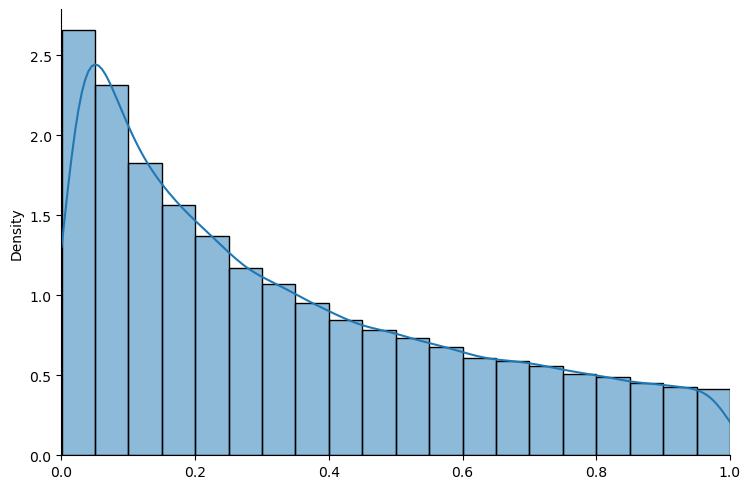

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


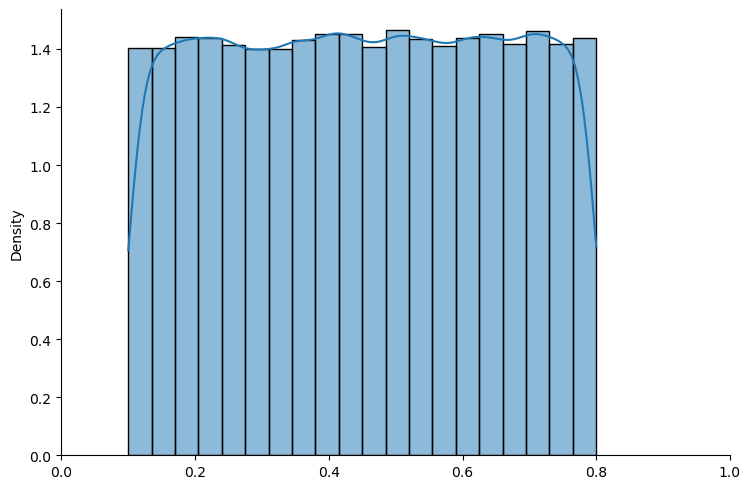

In [6]:
# truncated log normal
exampleLN = BayesianInference(param=(0,2), name_dist='lognormal', solver='numpyro')
exampleLN.show_prior(size=100000,bins=20)

# truncated uniform
exampleUN = BayesianInference(param=(0.1,0.8), name_dist='uniform', solver='numpyro')
exampleUN.show_prior(size=100000,bins=20)

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


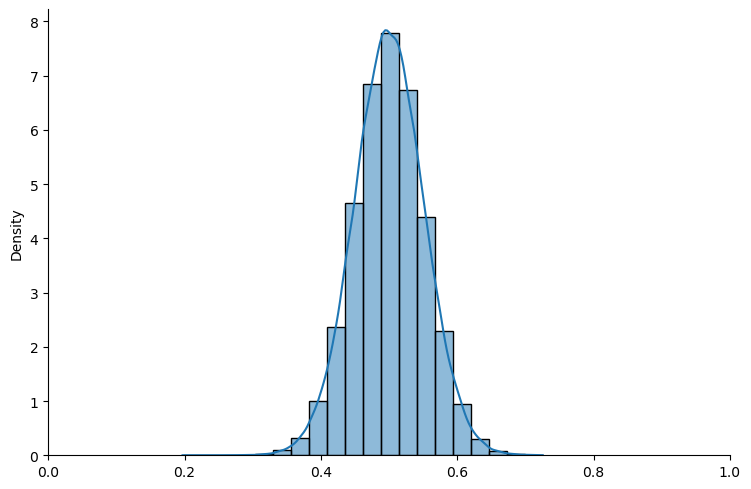

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


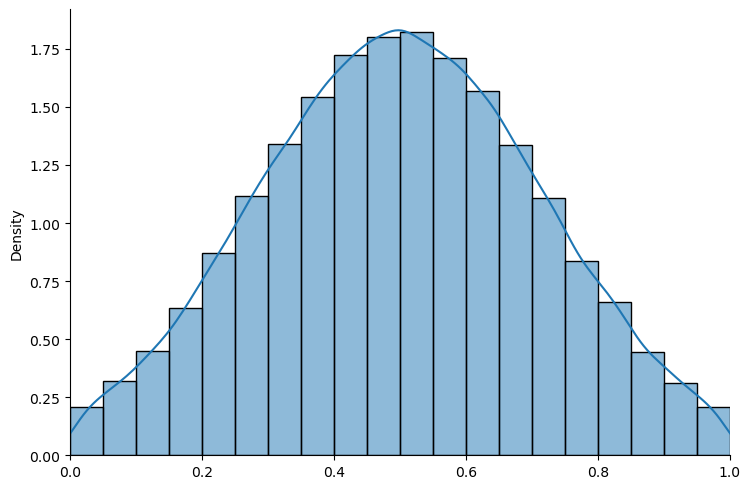

In [7]:
# shifted von Mises
exampleVM = BayesianInference(param=10, name_dist='vonMises', solver='numpyro')
exampleVM.show_prior(size=100000,bins=20)

# truncated von Mises
exampleVM_trunc = BayesianInference(param=20, name_dist='vonMises', solver='pyro')
exampleVM_trunc.show_prior(size=100000,bins=20)

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


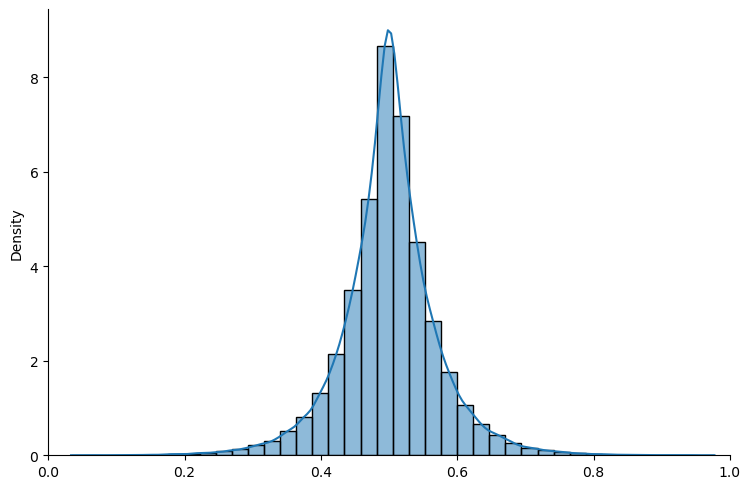

In [8]:
# truncated Laplace
exampleLP = BayesianInference(param=(0.5,0.05), name_dist='laplace', solver='numpyro')
exampleLP.show_prior(size=100000,bins=40)

In [9]:
class BayesianInferencePlot:
    """
    Easily implement the MCMC and VI inference for a given instance of BayesianInference class and
    plot the prior together with multiple posteriors

    Parameters
    ----------
    theta : float.
        the true DGP parameter
    N_list : list.
        a list of sample size
    BayesianInferenceClass : class.
        a class initiated using BayesianInference()

    """

    def __init__(self, theta, N_list, BayesianInferenceClass, binwidth=0.02):
        """
        Enter Parameters for data generation and plotting
        """
        self.theta = theta
        self.N_list = N_list
        self.BayesianInferenceClass = BayesianInferenceClass

        # plotting parameters
        self.binwidth = binwidth
        self.linewidth=0.05
        self.colorlist = sns.color_palette(n_colors=len(N_list))

        # data generation
        N_max = max(N_list)
        self.data = simulate_draw(theta, N_max)

    
    def MCMC_plot(self, num_samples, num_warmup=1000):
        """
        Parameters as in MCMC_sampling except that data is already defined
        """
        fig, ax = plt.subplots(figsize=(10, 6))

        # plot prior
        prior_sample = self.BayesianInferenceClass.show_prior(disp_plot=0)
        sns.histplot(
            data=prior_sample, kde=True, stat='density', 
            binwidth=self.binwidth,
            color='#4C4E52', 
            linewidth=self.linewidth,
            alpha=0.1,
            ax=ax,
            label='Prior Distribution'
            )

        # plot posteriors
        for id, n in enumerate(self.N_list):
            samples = self.BayesianInferenceClass.MCMC_sampling(
                self.data[:n], num_samples, num_warmup
            )
            sns.histplot(
                samples, kde=True, stat='density', 
                binwidth=self.binwidth, 
                linewidth=self.linewidth,
                alpha=0.2,
                color=self.colorlist[id-1],
                label=f'Posterior with $n={n}$'
                )
        ax.legend()
        ax.set_title('MCMC Sampling density of Posterior Distributions', fontsize=15)
        plt.xlim(0, 1)
        plt.show()


    def SVI_fitting(self, guide_dist, params):
        """
        Fit the beta/truncnormal curve using parameters trained by SVI. 
        I create plot using PDF given by scipy.stats distributions since torch.dist do not have embedded PDF methods.
        """
        # create x axis
        xaxis = np.linspace(0,1,1000)
        if guide_dist=='beta':
            y = st.beta.pdf(xaxis, a=params['alpha_q'], b=params['beta_q'])

        elif guide_dist=='normal':

            # rescale upper/lower bound. See Scipy's truncnorm doc
            lower, upper = (0, 1)
            loc, scale = params['loc'], params['scale']
            a, b = (lower - loc) / scale, (upper - loc) / scale

            y = st.truncnorm.pdf(xaxis, a=a, b=b, loc=params['loc'], scale=params['scale'])
        return (xaxis, y)
        

    def SVI_plot(self, guide_dist, n_steps=2000):
        """
        Parameters as in SVI_run except that data is already defined
        """
        fig, ax = plt.subplots(figsize=(10, 6))

        # plot prior
        prior_sample = self.BayesianInferenceClass.show_prior(disp_plot=0)
        sns.histplot(
            data=prior_sample, kde=True, stat='density', 
            binwidth=self.binwidth,
            color='#4C4E52', 
            linewidth=self.linewidth,
            alpha=0.1,
            ax=ax,
            label='Prior Distribution'
            )

        # plot posteriors
        for id, n in enumerate(self.N_list):
            (params, losses) = self.BayesianInferenceClass.SVI_run(self.data[:n], guide_dist, n_steps)
            x, y = self.SVI_fitting(guide_dist, params)
            ax.plot(x, y,
                alpha=1,
                color=self.colorlist[id-1],
                label=f'Posterior with $n={n}$'
                )
        ax.legend()
        ax.set_title(f'SVI density of Posterior Distributions with {guide_dist} guide', fontsize=15)
        plt.xlim(0, 1)
        plt.show()

In [10]:
num_list = [5,10,50,100,1000]
MCMC_num_samples = 2000
SVI_num_steps = 5000

# theta is the data generating process
true_theta = 0.8

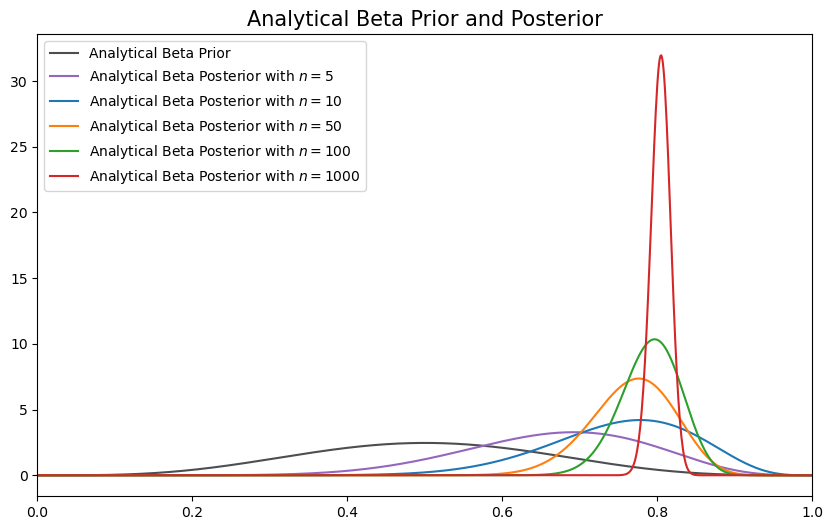

In [11]:
# First examine Beta priors
BETA_pyro = BayesianInference(param=(5,5), name_dist='beta', solver='pyro')
BETA_numpyro = BayesianInference(param=(5,5), name_dist='beta', solver='numpyro')

BETA_pyro_plot = BayesianInferencePlot(true_theta, num_list, BETA_pyro)
BETA_numpyro_plot = BayesianInferencePlot(true_theta, num_list, BETA_numpyro)


# plot analytical Beta prior and posteriors
xaxis = np.linspace(0,1,1000)
y_prior = st.beta.pdf(xaxis, 5, 5)

fig, ax = plt.subplots(figsize=(10, 6))
# plot analytical beta prior
ax.plot(xaxis, y_prior, label='Analytical Beta Prior', color='#4C4E52')

data, colorlist, N_list = BETA_pyro_plot.data, BETA_pyro_plot.colorlist, BETA_pyro_plot.N_list
# plot analytical beta posteriors
for id, n in enumerate(N_list):
    func = analytical_beta_posterior(data[:n], alpha0=5, beta0=5)
    y_posterior = func.pdf(xaxis)
    ax.plot(
        xaxis, y_posterior, color=colorlist[id-1], label=f'Analytical Beta Posterior with $n={n}$')
ax.legend()
ax.set_title('Analytical Beta Prior and Posterior', fontsize=15)
plt.xlim(0, 1)
plt.show()

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


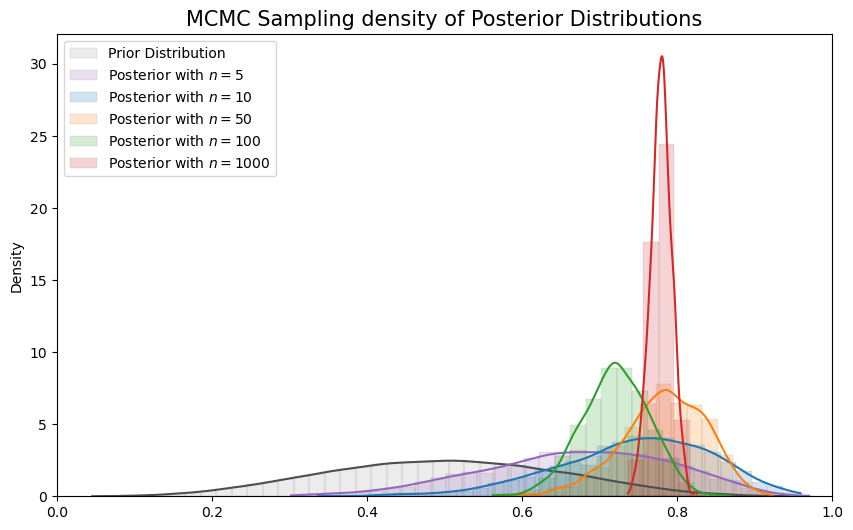

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


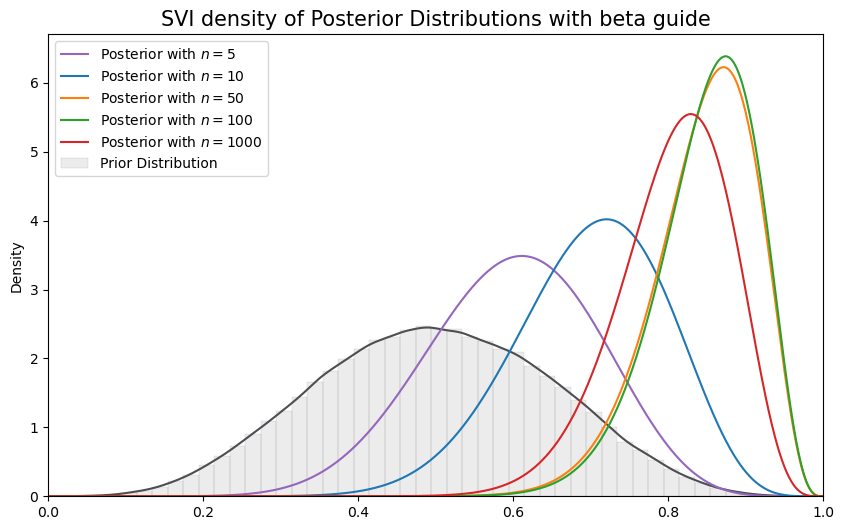

In [12]:
BayesianInferencePlot(true_theta, num_list, BETA_pyro).MCMC_plot(num_samples=MCMC_num_samples)
BayesianInferencePlot(true_theta, num_list, BETA_numpyro).SVI_plot(guide_dist='beta', n_steps=SVI_num_steps)

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


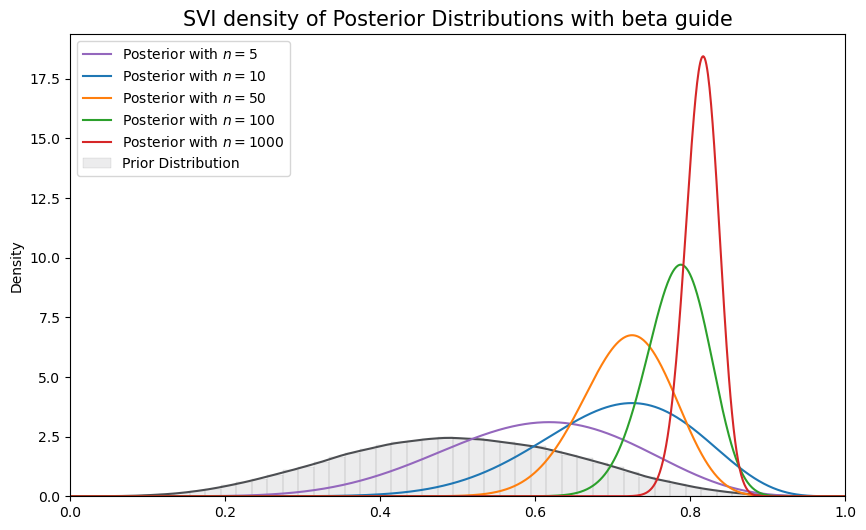

In [13]:
BayesianInferencePlot(true_theta, num_list, BETA_numpyro).SVI_plot(guide_dist='beta', n_steps=100000)

In [14]:
# Initialize BayesianInference classes
# try uniform
STD_UNIFORM_pyro = BayesianInference(param=(0,1), name_dist='uniform', solver='pyro')
UNIFORM_numpyro = BayesianInference(param=(0.2,0.7), name_dist='uniform', solver='numpyro')

# try truncated lognormal
LOGNORMAL_numpyro = BayesianInference(param=(0,2), name_dist='lognormal', solver='numpyro')
LOGNORMAL_pyro = BayesianInference(param=(0,2), name_dist='lognormal', solver='pyro')

# try von Mises
# shifted von Mises
VONMISES_numpyro = BayesianInference(param=10, name_dist='vonMises', solver='numpyro')
# truncated von Mises
VONMISES_pyro = BayesianInference(param=40, name_dist='vonMises', solver='pyro')

# try laplace
LAPLACE_numpyro = BayesianInference(param=(0.5, 0.07), name_dist='laplace', solver='numpyro')

=======INFO=======
Parameters: (0, 1)
Prior Dist: uniform
Solver: pyro


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


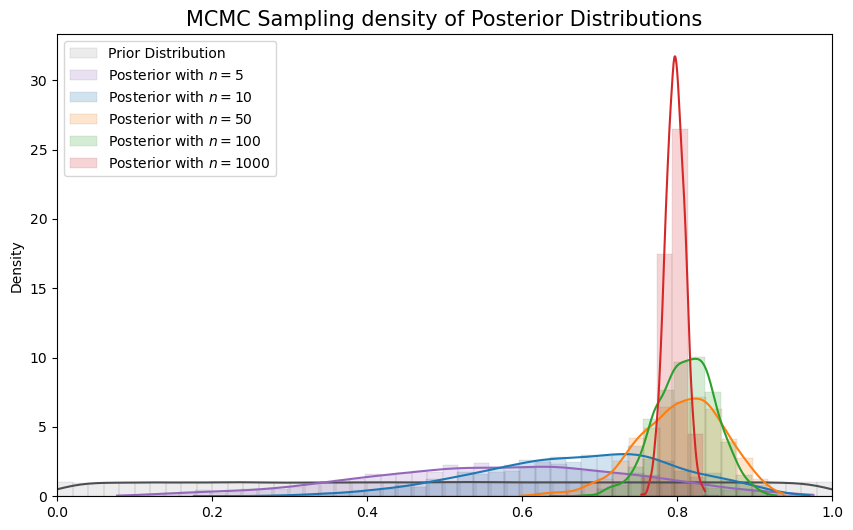

=======INFO=======
Parameters: (0.2, 0.7)
Prior Dist: uniform
Solver: numpyro


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


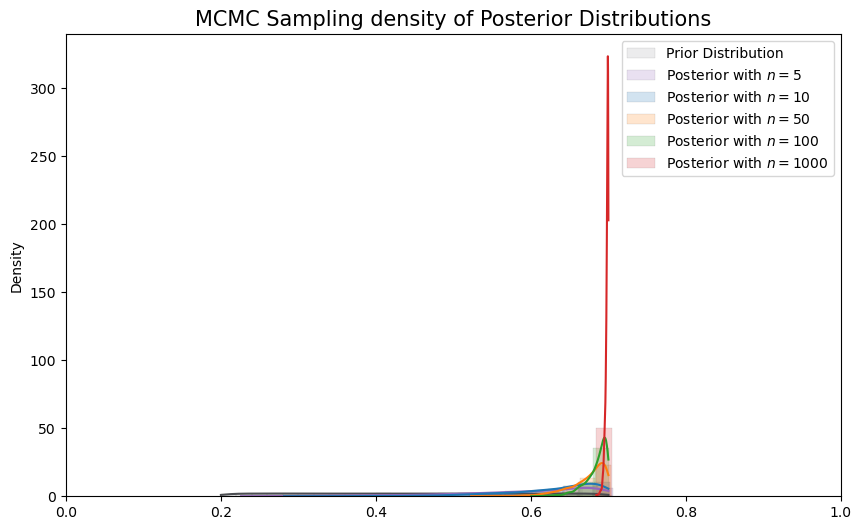

In [15]:
# Uniform
example_CLASS = STD_UNIFORM_pyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).MCMC_plot(num_samples=MCMC_num_samples)

example_CLASS = UNIFORM_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).MCMC_plot(num_samples=MCMC_num_samples)

=======INFO=======
Parameters: (0, 2)
Prior Dist: lognormal
Solver: numpyro


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


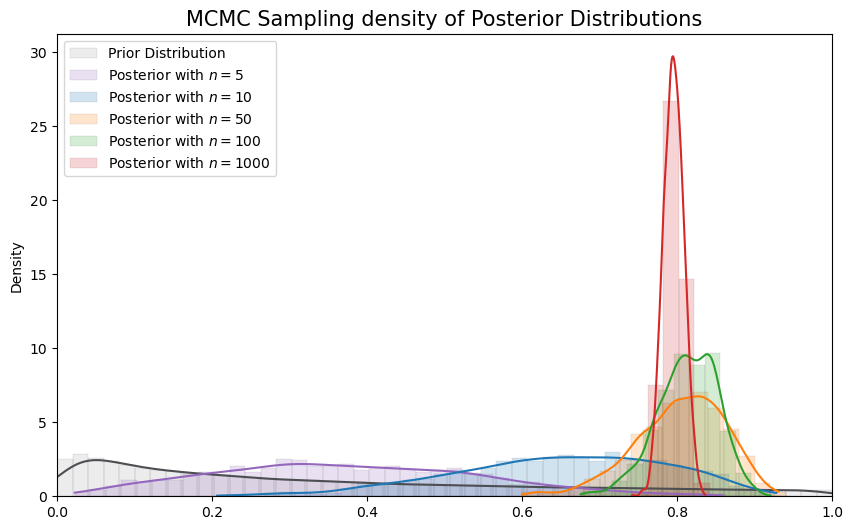

=======INFO=======
Parameters: (0, 2)
Prior Dist: lognormal
Solver: pyro


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


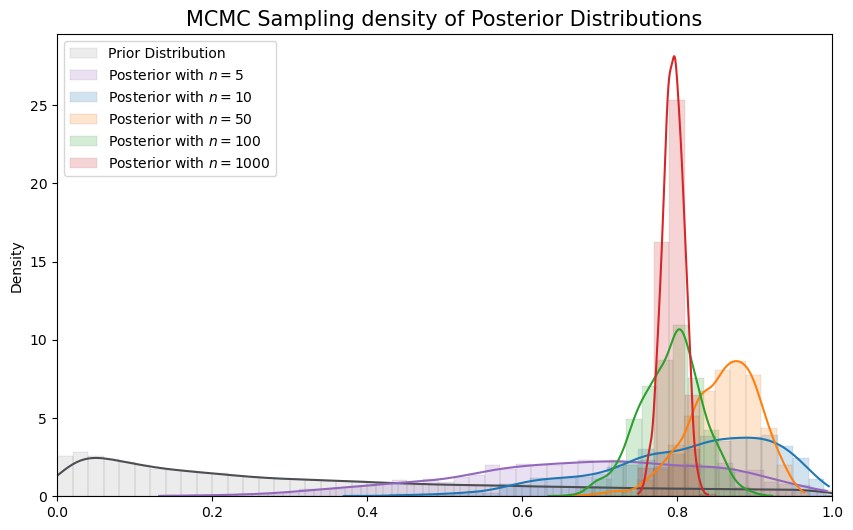

In [16]:
# Log Normal
example_CLASS = LOGNORMAL_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).MCMC_plot(num_samples=MCMC_num_samples)

example_CLASS = LOGNORMAL_pyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).MCMC_plot(num_samples=MCMC_num_samples)

=======INFO=======
Parameters: 10
Prior Dist: vonMises
Solver: numpyro

NOTE: Shifted von Mises


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


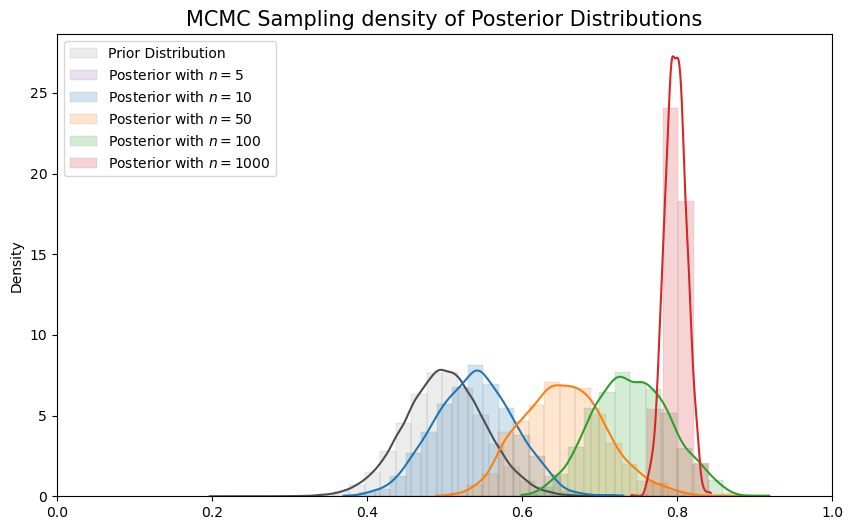

=======INFO=======
Parameters: 40
Prior Dist: vonMises
Solver: pyro

NOTE: Truncated von Mises


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


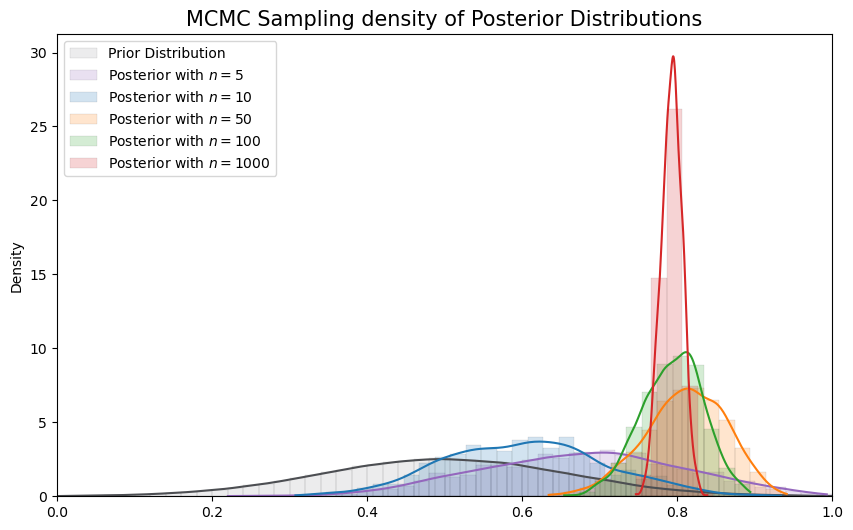

In [17]:
# Von Mises
example_CLASS = VONMISES_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
print('\nNOTE: Shifted von Mises')
BayesianInferencePlot(true_theta, num_list, example_CLASS).MCMC_plot(num_samples=MCMC_num_samples)

example_CLASS = VONMISES_pyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
print('\nNOTE: Truncated von Mises')
BayesianInferencePlot(true_theta, num_list, example_CLASS).MCMC_plot(num_samples=MCMC_num_samples)

=======INFO=======
Parameters: (0.5, 0.07)
Prior Dist: laplace
Solver: numpyro


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


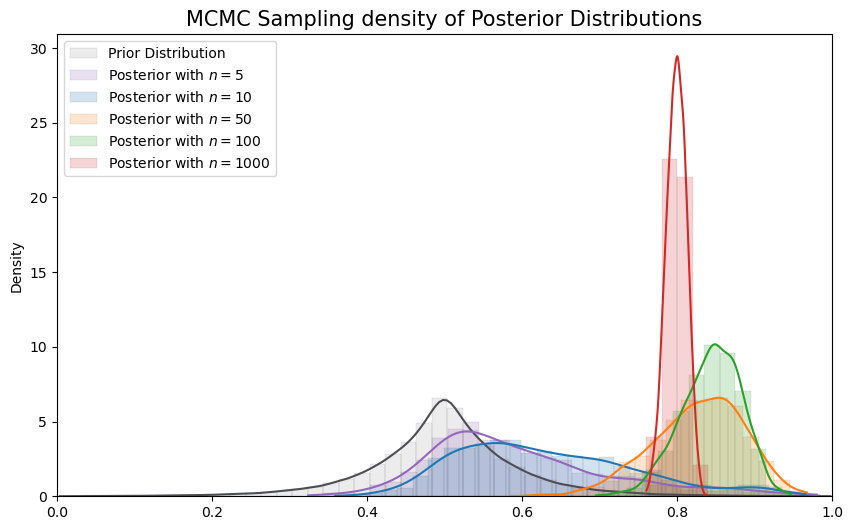

In [18]:
# Laplace
example_CLASS = LAPLACE_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).MCMC_plot(num_samples=MCMC_num_samples)

In [19]:
SVI_num_steps = 50000

=======INFO=======
Parameters: (0, 1)
Prior Dist: uniform
Solver: numpyro


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


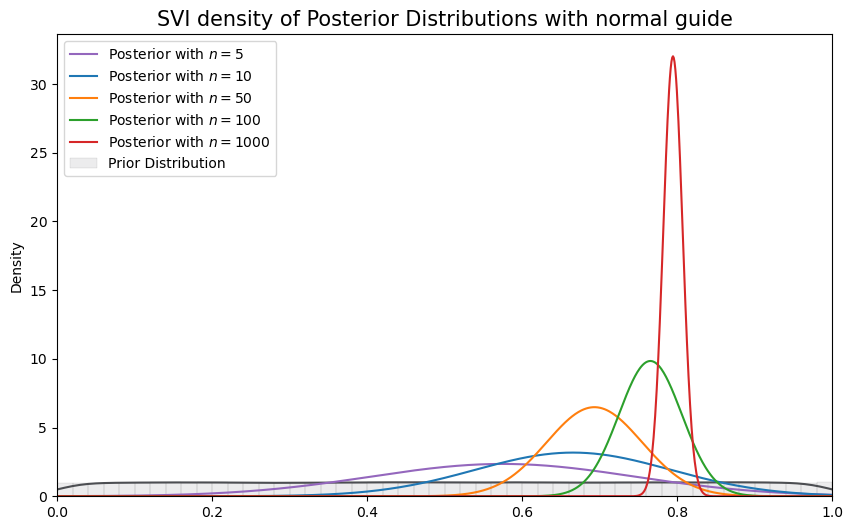

In [20]:
# Uniform
example_CLASS = BayesianInference(param=(0,1), name_dist='uniform', solver='numpyro')
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='normal', n_steps=SVI_num_steps)


=======INFO=======
Parameters: (0, 2)
Prior Dist: lognormal
Solver: numpyro


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


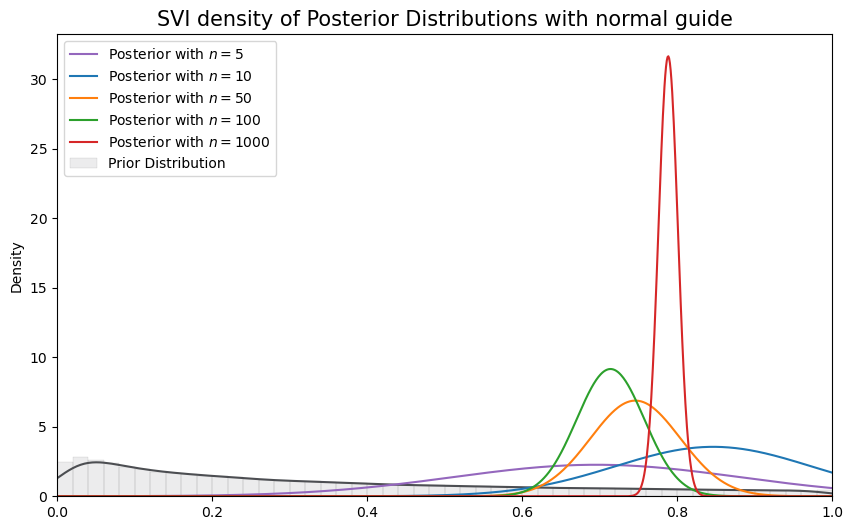

In [21]:
# Log Normal
example_CLASS = LOGNORMAL_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='normal', n_steps=SVI_num_steps)

=======INFO=======
Parameters: 10
Prior Dist: vonMises
Solver: numpyro

NB: Shifted von Mises


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


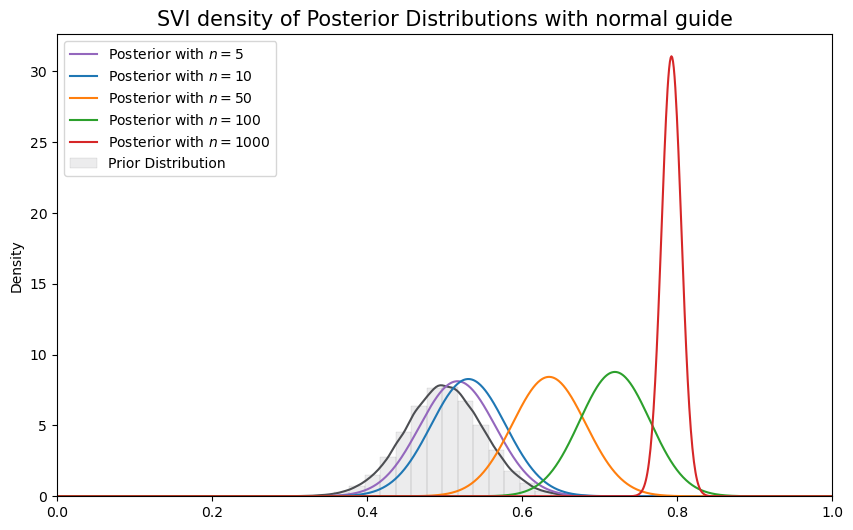

In [22]:
# Von Mises
example_CLASS = VONMISES_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
print('\nNB: Shifted von Mises')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='normal', n_steps=SVI_num_steps)

=======INFO=======
Parameters: (0.5, 0.07)
Prior Dist: laplace
Solver: numpyro


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


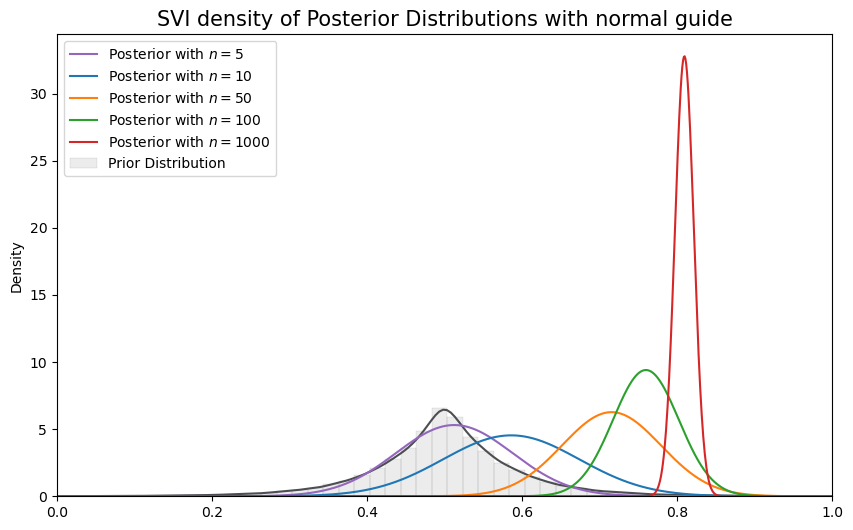

In [23]:
# Laplace
example_CLASS = LAPLACE_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='normal', n_steps=SVI_num_steps)

=======INFO=======
Parameters: (0, 1)
Prior Dist: uniform
Solver: pyro


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


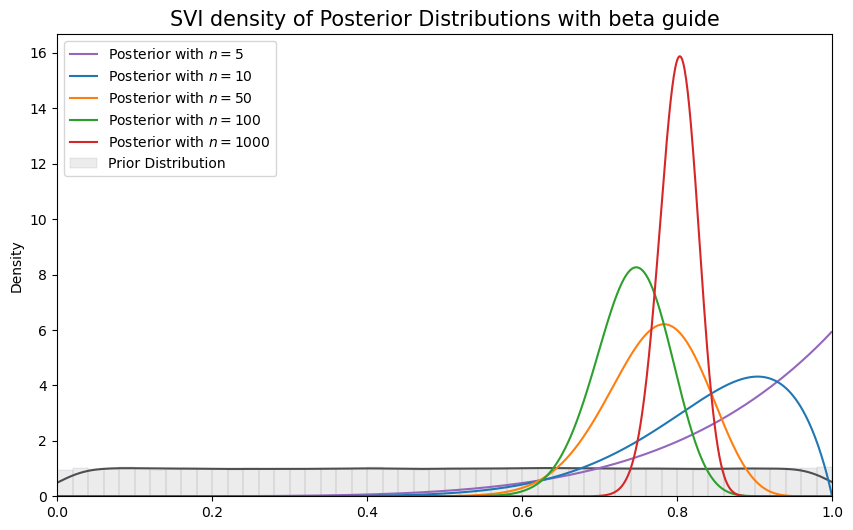

In [24]:
# Uniform
example_CLASS = STD_UNIFORM_pyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='beta', n_steps=SVI_num_steps)

=======INFO=======
Parameters: (0, 2)
Prior Dist: lognormal
Solver: numpyro


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


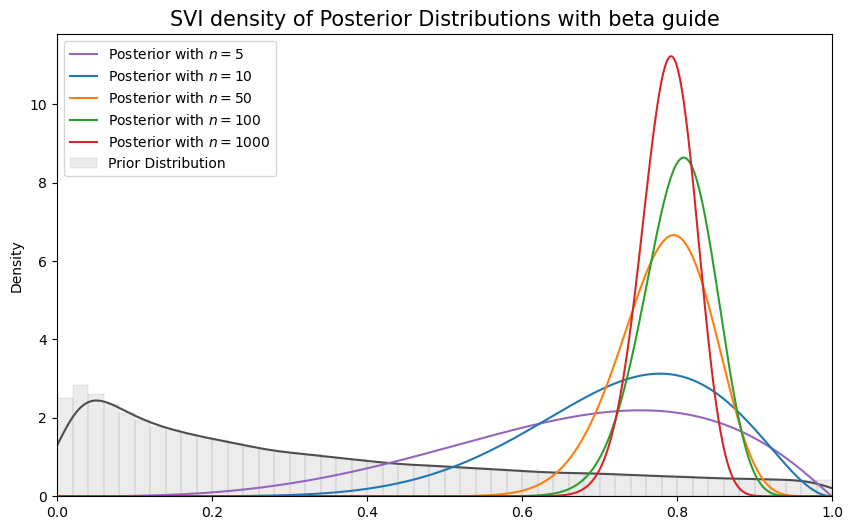

=======INFO=======
Parameters: (0, 2)
Prior Dist: lognormal
Solver: pyro


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


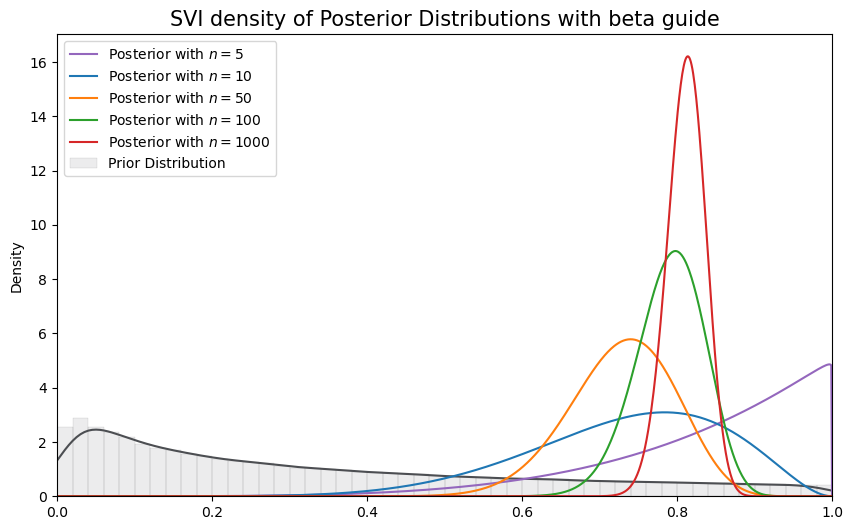

In [25]:
# Log Normal
example_CLASS = LOGNORMAL_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='beta', n_steps=SVI_num_steps)

example_CLASS = LOGNORMAL_pyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='beta', n_steps=SVI_num_steps)

=======INFO=======
Parameters: 10
Prior Dist: vonMises
Solver: numpyro

NB: Shifted von Mises


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


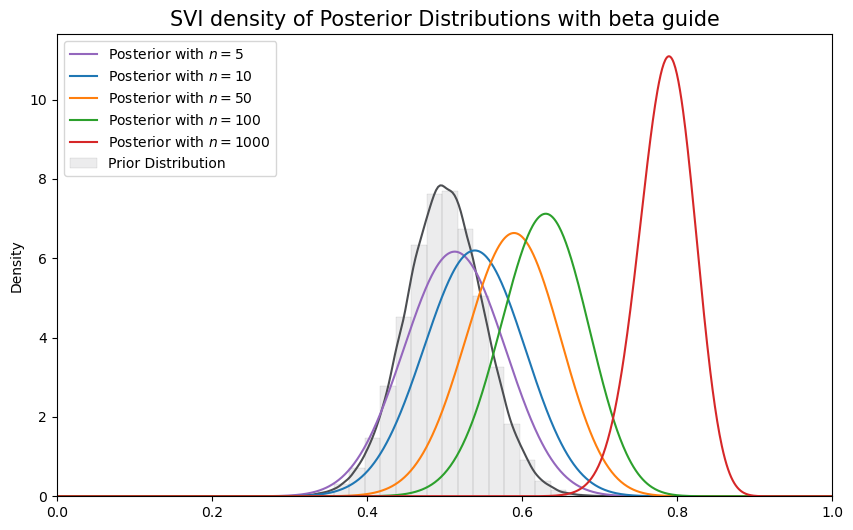

=======INFO=======
Parameters: 40
Prior Dist: vonMises
Solver: pyro

NB: Truncated von Mises


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


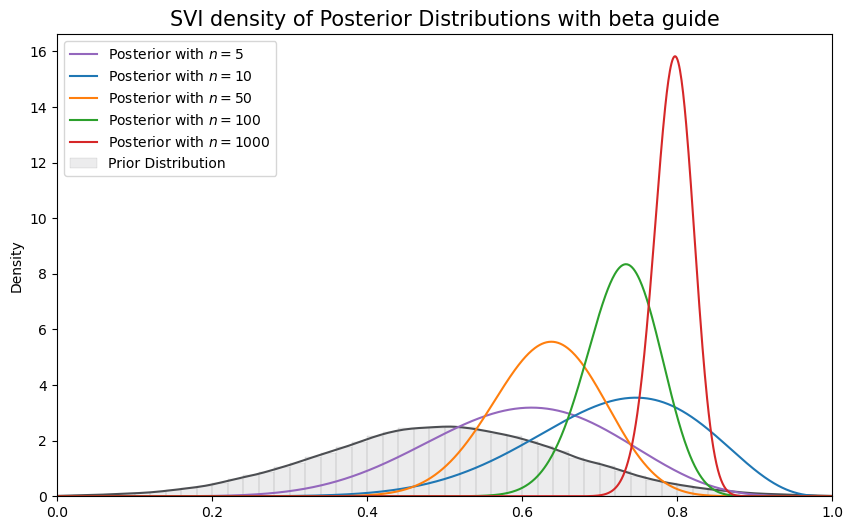

In [26]:
# Von Mises
example_CLASS = VONMISES_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
print('\nNB: Shifted von Mises')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='beta', n_steps=SVI_num_steps)

example_CLASS = VONMISES_pyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
print('\nNB: Truncated von Mises')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='beta', n_steps=SVI_num_steps)

=======INFO=======
Parameters: (0.5, 0.07)
Prior Dist: laplace
Solver: numpyro


/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


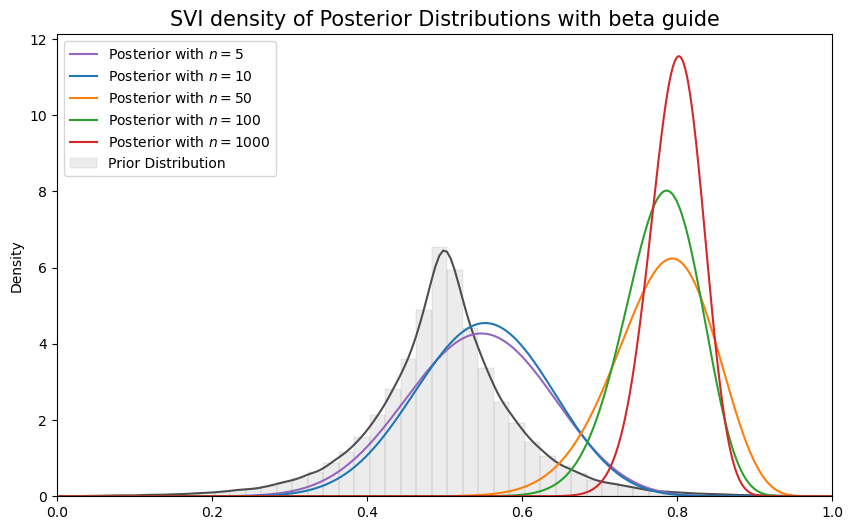

In [27]:
# Laplace
example_CLASS = LAPLACE_numpyro
print(f'=======INFO=======\nParameters: {example_CLASS.param}\nPrior Dist: {example_CLASS.name_dist}\nSolver: {example_CLASS.solver}')
BayesianInferencePlot(true_theta, num_list, example_CLASS).SVI_plot(guide_dist='beta', n_steps=SVI_num_steps)